In [1]:
from datasets import load_dataset
from transformers import (AutoModel, AutoTokenizer,
                          BertForTokenClassification, get_linear_schedule_with_warmup, 
                          AdamW, get_scheduler)

import string
import torch
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import evaluate


## Silence annoying warnings
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)


In [2]:


dataset_name = "Babelscape/multinerd"
model_name = "bert-base-cased" # Basic bert model - cased since the text is cased and it probably helps label entities like "Johnny Depp"


device = "cuda" if torch.cuda.is_available() else "cpu"


# For reproducibility
torch.manual_seed(1337)


tokenizer = AutoTokenizer.from_pretrained(model_name)


# Load data & Remove non-english items

In [3]:

# Loads data, only keeps english, removes language column
dataset_eng = load_dataset(dataset_name).filter(lambda x: x["lang"] == "en").remove_columns("lang")

Found cached dataset json (C:/Users/NicHer/.cache/huggingface/datasets/Babelscape___json/Babelscape--multinerd-f822e910a4f604c0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\NicHer\.cache\huggingface\datasets\Babelscape___json\Babelscape--multinerd-f822e910a4f604c0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-eb9ab4cbc9b9233f.arrow
Loading cached processed dataset at C:\Users\NicHer\.cache\huggingface\datasets\Babelscape___json\Babelscape--multinerd-f822e910a4f604c0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-eed54e3e6216fb0e.arrow
Loading cached processed dataset at C:\Users\NicHer\.cache\huggingface\datasets\Babelscape___json\Babelscape--multinerd-f822e910a4f604c0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-fe66576485de1b0f.arrow


# Data exploration

### Itos & Stoi

In [4]:
#Mapping from integer labels to strings (from HF dataset repo) and vice versa

stoi = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }



itos = {value:key for key,value in stoi.items()}

LABEL_MAPPING = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 13: 9, 14: 10}
INVERSE_LABEL_MAPPING = {v: k for k, v in LABEL_MAPPING.items()}

### Plotting

In [82]:

# Uneven class distribution 
nercounts = dict(Counter([item for sublist in dataset_eng["train"]["ner_tags"] for item in sublist]))
nercounts

{0: 4957198,
 5: 117330,
 25: 14872,
 26: 4702,
 1: 125974,
 2: 132376,
 13: 17404,
 14: 11608,
 9: 280,
 21: 12162,
 22: 20070,
 6: 48800,
 3: 55282,
 4: 71998,
 27: 5080,
 7: 25472,
 8: 10614,
 15: 5050,
 16: 8406,
 28: 3942,
 11: 5370,
 12: 2972,
 17: 16558,
 18: 6060,
 29: 808,
 30: 956,
 23: 1138,
 24: 202,
 19: 758,
 20: 726,
 10: 70}

In [84]:

# Actually not that big of a difference between O values
print("O values in system A: ", nercounts[0])
o_counts = 0
for k,v in nercounts.items():
    if k not in LABEL_MAPPING.keys():
        o_counts += v
print("O values in system B: ", o_counts)
        

O values in system A:  4957198
O values in system B:  5067380


In [7]:
# Filter 0 for plotting
nercounts = {k:v for k,v in nercounts.items() if k != 0}

Text(0, 0.5, 'Counts')

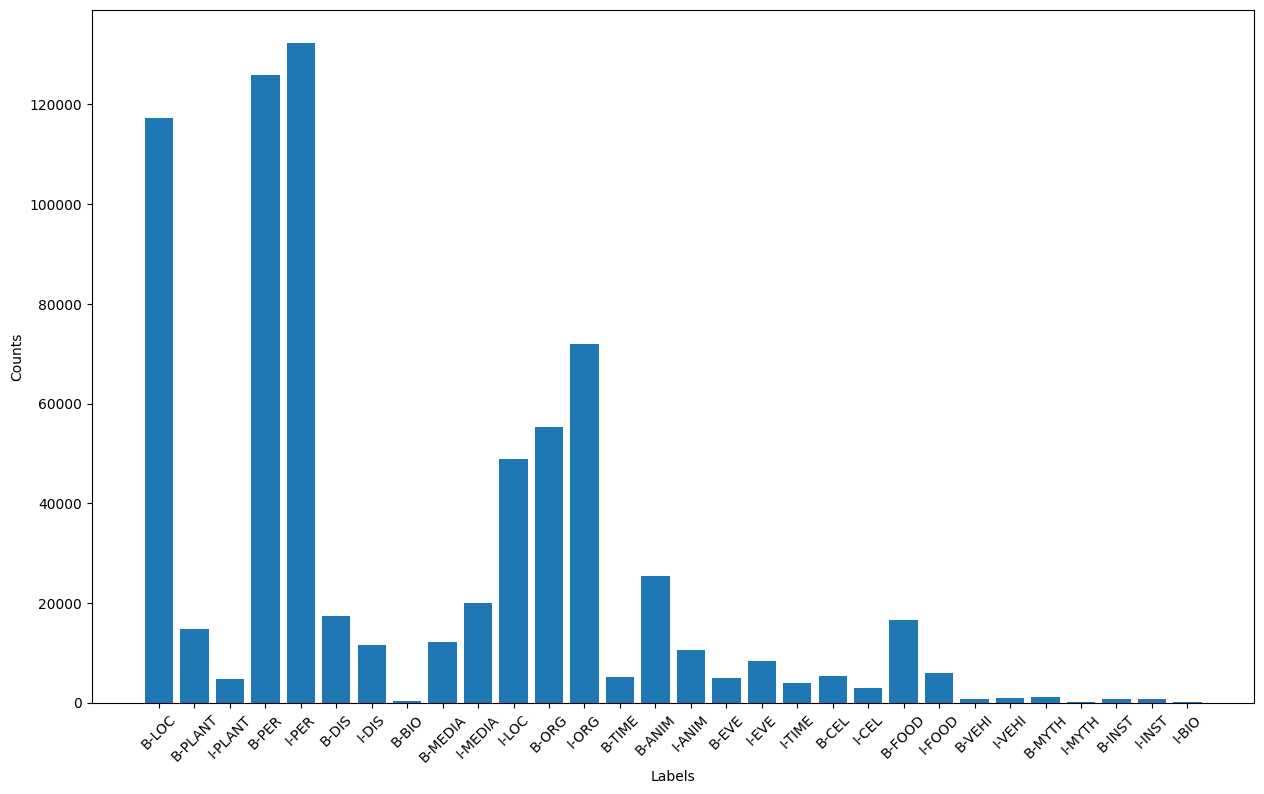

In [8]:
# Bar plots

labels = [itos[x] for x in list(nercounts.keys())]
counts = nercounts.values()

plt.figure(figsize=(15, 9))
plt.bar(labels, counts)

plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Counts')


(array([2.0370e+04, 6.6838e+04, 7.2900e+04, 5.4448e+04, 2.3796e+04,
        1.2156e+04, 6.2960e+03, 2.6360e+03, 1.4500e+03, 7.1200e+02,
        4.1000e+02, 2.1800e+02, 1.3600e+02, 7.0000e+01, 2.6000e+01,
        2.2000e+01, 2.2000e+01, 1.6000e+01, 8.0000e+00, 6.0000e+00,
        6.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  2. ,  10.3,  18.6,  26.9,  35.2,  43.5,  51.8,  60.1,  68.4,
         76.7,  85. ,  93.3, 101.6, 109.9, 118.2, 126.5, 134.8, 143.1,
        151.4, 159.7, 168. , 176.3, 184.6, 192.9, 201.2, 209.5, 217.8,
        226.1, 234.4, 242.7, 251. , 259.3, 267.6, 275.9, 284.2, 292.5,
        300.8, 309.1, 317.4, 325.7, 334. ]),
 <BarContainer object of 40 artists>)

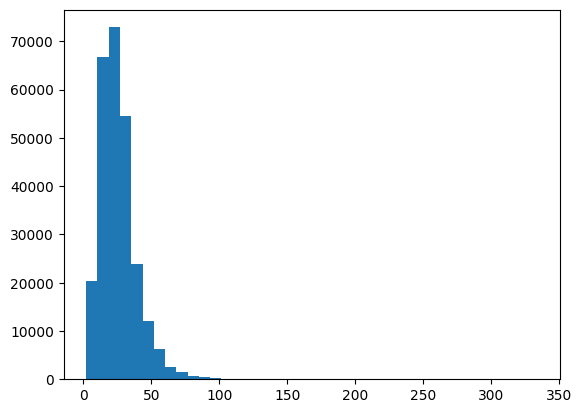

In [9]:
# Most texts are short, can get away with low max token length

tokenized_sent_lengths = [len(tokenizer.tokenize(" ".join(x))) for x in dataset_eng["train"]["tokens"]]

plt.hist(tokenized_sent_lengths, bins=40)

In [10]:
# Around 99 % of sentences are less than 70 tokens
len([x for x in tokenized_sent_lengths if x < 70]) / len(tokenized_sent_lengths)

0.9890158439975625

# Preprocessing

In [11]:



#Taken from HF, to align the ner labels with tokenized words
def align_labels_with_tokens(labels, word_ids, max_length):
    new_labels = []
    current_word = None
    
    # Word ids are mappings between original words and tokens, ie [hej jag heter] => [hej jag het #er] => [0,1,2,2]
    for word_id in word_ids:
        if word_id != current_word:
            # New word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]   #-100 to not take into account during loss function
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)                                #-100 for special tokens
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels[:max_length]    # Truncates labels to match max length



def to_tensor_dataset(data, labels):
    # Effectively zips the data and labels
    inp_ids = data["input_ids"]
    atmask = data["attention_mask"]
    return TensorDataset(inp_ids, atmask, labels)



def label_fix(labels):
    # Input is a nested list of labels => mapped allowed labels
    return [[LABEL_MAPPING.get(x, 0) for x in sublist] for sublist in labels]
    



def prepare_data(dataset, splitname, all_labels, max_length=70):
    # Dataset, split, all_labels or subset => Returns torch tensors
    
    splitname = splitname
    sents = dataset[splitname]["tokens"]
    labels = dataset[splitname]["ner_tags"]
    label_mapping = None
    inverse_label_mapping = None
    
    # Change labels if all_labels = False
    # A bit slow - would be faster with tensor operations
    if not all_labels:
        labels = label_fix(labels) 
    
    assert len(sents) == len(labels) # Sanity check
    
    # Tokenize and align labels, currently pad everything to the same length
    tokenized_sents = tokenizer(sents, 
                                is_split_into_words=True,   # Input came as lists
                                add_special_tokens=True,    # CLS and SEP
                                padding="max_length",       # Pad shorter sequences
                                truncation=True,            # Truncates longer sequences
                                max_length=max_length,      # Set to 70 by default
                                return_tensors="pt")        # Pytorch tensors
    
    # Stack to turn list of torch tensors into one tensor
    aligned_labels = torch.stack([torch.tensor(
                                 align_labels_with_tokens(labels[i], 
                                 tokenized_sents[i].word_ids, 
                                 max_length)) 
                                 for i in range(len(labels))])
    
    dataset = to_tensor_dataset(tokenized_sents, aligned_labels)
    
    return dataset




all_labels = False

# Tokenizes, aligns labels and turns to torch tensors

training_dataset = prepare_data(dataset_eng, "train", all_labels)
evaluation_dataset = prepare_data(dataset_eng, "validation", all_labels)
testing_dataset = prepare_data(dataset_eng, "test", all_labels)

# Training

In [14]:




def init_model(training_dataset, model_name, tokenizer, device):
    
    num_labels = len(torch.unique(torch.cat([x[2] for x in training_dataset]))) - 1
    
    # The model probably doesnt need to be more complicated than this, the context is usually very short
    model = BertForTokenClassification.from_pretrained(model_name, 
                                                   num_labels=num_labels, 
                                                   vocab_size=tokenizer.vocab_size, 
                                                   ignore_mismatched_sizes=True).to(device)

    
    return model

def ret_dataloaders(training_dataset, evaluation_dataset, batch_size, shuffle=False):
    train_loader = DataLoader(training_dataset, 
                              batch_size=batch_size, 
                              shuffle=shuffle) #False for reproducibility for now
    
    eval_loader = DataLoader(evaluation_dataset,
                             batch_size=batch_size, 
                             shuffle=shuffle) #False for reproducibility for now
    
    return train_loader, eval_loader


def train_epoch(train_loader, scheduler, optimizer, model, hyperparameter_search, i, max_batches=None):
    model.train()
    train_loss = 0
    t_lossi = []
    
    for j,batch in enumerate(train_loader):
        _ids, at, lab = batch 
        out = model(input_ids=_ids.to(model.device), 
                    attention_mask=at.to(model.device), 
                    labels=lab.to(model.device)) #   logits = [256, 40, 31] B,T,C, loss is NLL
        train_loss += out.loss.item()

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
                                       max_norm=1) #gradient clipping - safety net

        optimizer.zero_grad() # Zero gradients between each update
        out.loss.backward()   # Calculate gradients
        optimizer.step()      # Step

        if scheduler:         # Update learning rate
            scheduler.step()

        if j % 25 == 0 and j > 0:
            print("Average T loss at step {}: {}".format(j, train_loss / j ))
            t_lossi.append(train_loss / j)
            
        
        if max_batches is not None and j >= max_batches:
            break
            
    
    return model, t_lossi
    


def eval_epoch(eval_loader, model):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for j,batch in enumerate(eval_loader):
            
            _ids, at, lab = batch
            out = model(input_ids=_ids.to(model.device), 
                        attention_mask=at.to(model.device), 
                        labels=lab.to(model.device))
            eval_loss += out.loss.item()
            
    avg_eval_loss = eval_loss / len(eval_loader)
    return avg_eval_loss




def train_model(params, model, training_dataset, evaluation_dataset, hyperparameter_search=True):
    
    train_loader, eval_loader = ret_dataloaders(training_dataset, evaluation_dataset, params["batch_size"])
    optimizer = AdamW(params = model.parameters(), lr=params["lr"])
    
    total_steps = (len(training_dataset) // params["batch_size"]) * params["epochs"]
    warmup_steps = int(total_steps * params["warmup_steps"]) #standard 10th
    scheduler = get_scheduler("linear", 
                              optimizer=optimizer, 
                              num_warmup_steps= warmup_steps, ##set warmup steps to 0.1 * total num steps 
                              num_training_steps=total_steps)
    
    
    # Early stopping for hyperparameter search
    if hyperparameter_search:
        max_batches = 3000
    else:
        max_batches = None
    
    for i in range(1, params["epochs"] + 1):
        model, t_loss = train_epoch(train_loader, scheduler, optimizer, model, hyperparameter_search, i, max_batches)
        e_loss = eval_epoch(eval_loader, model)
        print("epoch: ", i)
        
    
    if hyperparameter_search:
        return t_loss, e_loss
    else:
        return model, t_loss, e_loss





In [15]:


def hyperparameter_combinations():
    # Currently checks all combinations
    
    learning_rates = [2e-5, 3e-5, 5e-5]
    batch_sizes = [16, 32]
    warmup_steps = [0, 0.1]


    hyperparameter_configs = []
    for lr in learning_rates:
        for bs in batch_sizes:
            for ws in warmup_steps:
                params = {
                "lr": lr,            # How much should the model adjust its parameters to fit the task per update
                "batch_size": bs,    # How large of a batch should the model use to guide its update
                "warmup_steps": ws,  # Should the LR "climb" up to the max value before decay or start at the top instantly
                "epochs" : 1         # Set to 1 since I use max batches in hyperparameter search anyways
            }
                hyperparameter_configs.append(params)
        
    return hyperparameter_configs



def hyperparameter_search(training_dataset, evaluation_dataset, tokenizer, device):
    
    hyperparameter_configs = hyperparameter_combinations()
    
    results = []
    for i,config in enumerate(hyperparameter_configs):
        model = init_model(training_dataset, model_name, tokenizer, device)
        t_loss, e_loss = train_model(config, model, training_dataset, evaluation_dataset, hyperparameter_search=True)
        results.append((config, t_loss, e_loss, i))
        print("--------------------------------")
        
    
    sorted_by_eval = sorted(results, key=lambda x: x[2])
    best_hyperparameters = sorted_by_eval[0][0]
    
    print(f"Best avg eval: {sorted_by_eval[0][2]}\nWorst avg eval: {sorted_by_eval[-1][2]}")
        
    return best_hyperparameters, results


best_hyperparameters, all_results = hyperparameter_search(training_dataset, evaluation_dataset, tokenizer, device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NicHer\AppData\Local\anaconda3\envs\envname2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Average T loss at step 25: 1.1309768104553222
Average T loss at step 50: 0.8260161483287811
Average T loss at step 75: 0.6628215177853902
Average T loss at step 100: 0.5619240575283766
Average T loss at step 125: 0.481671720802784
Average T loss at step 150: 0.4227159536381562
Average T loss at step 175: 0.37989355040448053
Average T loss at step 200: 0.34688961012288927
Average T loss at step 225: 0.31840800961686505
Average T loss at step 250: 0.294281979970634
Average T loss at step 275: 0.27513136617839334
Average T loss at step 300: 0.2582404685020447
Average T loss at step 325: 0.2460091012945542
Average T loss at step 350: 0.2342822326852807
Average T loss at step 375: 0.22354939770201843
Average T loss at step 400: 0.2136187682999298
Average T loss at step 425: 0.20352198109523778
Average T loss at step 450: 0.1955313467860429
Average T loss at step 475: 0.18770962065968075
Average T loss at step 500: 0.1805395873216912
Average T loss at step 525: 0.17351532144826792
Average T 

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 2.754968843460083
Average T loss at step 50: 2.663259630203247
Average T loss at step 75: 2.582252960205078
Average T loss at step 100: 2.4805246329307558
Average T loss at step 125: 2.3518356590270995
Average T loss at step 150: 2.191706831455231
Average T loss at step 175: 2.022640165601458
Average T loss at step 200: 1.8707065787911414
Average T loss at step 225: 1.7290871340698666
Average T loss at step 250: 1.6078986842632295
Average T loss at step 275: 1.5063974073800173
Average T loss at step 300: 1.4189652621746063
Average T loss at step 325: 1.3450317169152772
Average T loss at step 350: 1.2771716792242869
Average T loss at step 375: 1.2196375575065612
Average T loss at step 400: 1.170698176547885
Average T loss at step 425: 1.1189026484419318
Average T loss at step 450: 1.0739292446109983
Average T loss at step 475: 1.0278839610438597
Average T loss at step 500: 0.9855786073356867
Average T loss at step 525: 0.9449393739870616
Average T loss at step

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 1.1278169298171996
Average T loss at step 50: 0.8203186690807343
Average T loss at step 75: 0.6537956357002258
Average T loss at step 100: 0.5382321617007255
Average T loss at step 125: 0.4530070113539696
Average T loss at step 150: 0.3945885752886534
Average T loss at step 175: 0.3535827985405922
Average T loss at step 200: 0.3196033355779946
Average T loss at step 225: 0.2908831190566222
Average T loss at step 250: 0.2674407925158739
Average T loss at step 275: 0.24694071906872772
Average T loss at step 300: 0.23079995271128914
Average T loss at step 325: 0.2183948720389834
Average T loss at step 350: 0.2073189839960209
Average T loss at step 375: 0.19773510909825565
Average T loss at step 400: 0.18848108237143607
Average T loss at step 425: 0.180971072986722
Average T loss at step 450: 0.17388140452197856
Average T loss at step 475: 0.16835816531393089
Average T loss at step 500: 0.16338563646934925
Average T loss at step 525: 0.15869929903497298
Average T

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 2.501252326965332
Average T loss at step 50: 2.383800129890442
Average T loss at step 75: 2.2506617895762124
Average T loss at step 100: 2.069041644334793
Average T loss at step 125: 1.838155372619629
Average T loss at step 150: 1.638239041964213
Average T loss at step 175: 1.487527096782412
Average T loss at step 200: 1.3783464649319648
Average T loss at step 225: 1.2825828014479743
Average T loss at step 250: 1.1944607924222945
Average T loss at step 275: 1.1116115471991626
Average T loss at step 300: 1.0389101910591125
Average T loss at step 325: 0.9750822182343556
Average T loss at step 350: 0.9175473503768444
Average T loss at step 375: 0.865461283047994
Average T loss at step 400: 0.817563586877659
Average T loss at step 425: 0.7760895464613157
Average T loss at step 450: 0.7377983288715283
Average T loss at step 475: 0.7038131578305834
Average T loss at step 500: 0.6734704956971109
Average T loss at step 525: 0.6456968347905647
Average T loss at step 5

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 0.9851394748687744
Average T loss at step 50: 0.7024837589263916
Average T loss at step 75: 0.5429687860608101
Average T loss at step 100: 0.4477051867172122
Average T loss at step 125: 0.38218722818791867
Average T loss at step 150: 0.3350527186691761
Average T loss at step 175: 0.300829239657947
Average T loss at step 200: 0.2759426445513964
Average T loss at step 225: 0.25460371714499264
Average T loss at step 250: 0.2362082535251975
Average T loss at step 275: 0.22226913631639697
Average T loss at step 300: 0.20938908720389007
Average T loss at step 325: 0.20040857290419248
Average T loss at step 350: 0.19204166498567377
Average T loss at step 375: 0.18391665946443875
Average T loss at step 400: 0.17687752943485976
Average T loss at step 425: 0.16931936436223194
Average T loss at step 450: 0.163210539001868
Average T loss at step 475: 0.15697356015590852
Average T loss at step 500: 0.15156035294709727
Average T loss at step 525: 0.14594165864045777
Averag

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 2.382426700592041
Average T loss at step 50: 2.28945734500885
Average T loss at step 75: 2.192792134284973
Average T loss at step 100: 2.078135520219803
Average T loss at step 125: 1.9423602161407472
Average T loss at step 150: 1.7857674475510914
Average T loss at step 175: 1.646929306302752
Average T loss at step 200: 1.5302527251839637
Average T loss at step 225: 1.4174174851841397
Average T loss at step 250: 1.3188149174451829
Average T loss at step 275: 1.2356102509932085
Average T loss at step 300: 1.1622622594237328
Average T loss at step 325: 1.098528184890747
Average T loss at step 350: 1.0396218421629497
Average T loss at step 375: 0.9874830067157745
Average T loss at step 400: 0.9413420854881406
Average T loss at step 425: 0.8953350116663119
Average T loss at step 450: 0.8550596830331617
Average T loss at step 475: 0.8158793742797876
Average T loss at step 500: 0.7804209615215659
Average T loss at step 525: 0.7473731684826669
Average T loss at step 

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 1.0109399795532226
Average T loss at step 50: 0.696115974187851
Average T loss at step 75: 0.5279137089848518
Average T loss at step 100: 0.4306412392482162
Average T loss at step 125: 0.36338134977221487
Average T loss at step 150: 0.3178634739667177
Average T loss at step 175: 0.28657521726829666
Average T loss at step 200: 0.26084593071602286
Average T loss at step 225: 0.2380687580133478
Average T loss at step 250: 0.21923151528090237
Average T loss at step 275: 0.20252886273305523
Average T loss at step 300: 0.18973536547273398
Average T loss at step 325: 0.1800380054775339
Average T loss at step 350: 0.17171930291556886
Average T loss at step 375: 0.16414650974298517
Average T loss at step 400: 0.15634542061656248
Average T loss at step 425: 0.1505253636305604
Average T loss at step 450: 0.14477433591408448
Average T loss at step 475: 0.1405989325100458
Average T loss at step 500: 0.13684851175313814
Average T loss at step 525: 0.13328018919830875
Avera

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 2.2472406101226805
Average T loss at step 50: 2.099934792518616
Average T loss at step 75: 1.941398525238037
Average T loss at step 100: 1.7344505989551544
Average T loss at step 125: 1.5159152290821076
Average T loss at step 150: 1.3524502154191336
Average T loss at step 175: 1.225341376406806
Average T loss at step 200: 1.1303462582826613
Average T loss at step 225: 1.042312051322725
Average T loss at step 250: 0.9615798493623734
Average T loss at step 275: 0.8885415850986134
Average T loss at step 300: 0.8268180081496636
Average T loss at step 325: 0.7736045456391114
Average T loss at step 350: 0.7270304015704564
Average T loss at step 375: 0.6853090670108796
Average T loss at step 400: 0.6467670703609474
Average T loss at step 425: 0.6137262970844612
Average T loss at step 450: 0.5839051670270662
Average T loss at step 475: 0.5575036708010654
Average T loss at step 500: 0.5338738387208432
Average T loss at step 525: 0.5123079635078708
Average T loss at st

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 0.7900044417381287
Average T loss at step 50: 0.520804633051157
Average T loss at step 75: 0.39500458285212514
Average T loss at step 100: 0.3287866757251322
Average T loss at step 125: 0.28923188903927805
Average T loss at step 150: 0.25664711942275364
Average T loss at step 175: 0.2328171295779092
Average T loss at step 200: 0.2152521111164242
Average T loss at step 225: 0.2015853268156449
Average T loss at step 250: 0.1876944504790008
Average T loss at step 275: 0.17744658796963367
Average T loss at step 300: 0.16905178896772366
Average T loss at step 325: 0.16328307685084067
Average T loss at step 350: 0.15764332448797566
Average T loss at step 375: 0.15184602001309394
Average T loss at step 400: 0.14635528719751165
Average T loss at step 425: 0.14002381381387
Average T loss at step 450: 0.13554864308977913
Average T loss at step 475: 0.13090184662319523
Average T loss at step 500: 0.12613008109875953
Average T loss at step 525: 0.12162622286450295
Averag

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 2.535826358795166
Average T loss at step 50: 2.4038516330718993
Average T loss at step 75: 2.2441159772872923
Average T loss at step 100: 2.052664581537247
Average T loss at step 125: 1.8358651309013367
Average T loss at step 150: 1.6560123465458552
Average T loss at step 175: 1.5200967264175416
Average T loss at step 200: 1.4048271444439888
Average T loss at step 225: 1.294353081650204
Average T loss at step 250: 1.1989242679476737
Average T loss at step 275: 1.120499123768373
Average T loss at step 300: 1.0498464072247347
Average T loss at step 325: 0.9883707592579035
Average T loss at step 350: 0.9317163699865341
Average T loss at step 375: 0.8809500844875972
Average T loss at step 400: 0.835165002439171
Average T loss at step 425: 0.7915129561021047
Average T loss at step 450: 0.7532233553545342
Average T loss at step 475: 0.7167825785004779
Average T loss at step 500: 0.6843981573656202
Average T loss at step 525: 0.654525400322108
Average T loss at step

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 0.8040216910839081
Average T loss at step 50: 0.5250292757153511
Average T loss at step 75: 0.39349608078598974
Average T loss at step 100: 0.32376613523811104
Average T loss at step 125: 0.2746108024716377
Average T loss at step 150: 0.24150590432186922
Average T loss at step 175: 0.21963401051504272
Average T loss at step 200: 0.20083250150084495
Average T loss at step 225: 0.18389378596718112
Average T loss at step 250: 0.1704009335730225
Average T loss at step 275: 0.1578541014521298
Average T loss at step 300: 0.14912368504097684
Average T loss at step 325: 0.1423480953856443
Average T loss at step 350: 0.13650146776078534
Average T loss at step 375: 0.13096244412350158
Average T loss at step 400: 0.12525875590828947
Average T loss at step 425: 0.12090033199282034
Average T loss at step 450: 0.11667407632158655
Average T loss at step 475: 0.11405666250809046
Average T loss at step 500: 0.11169960229448042
Average T loss at step 525: 0.1093516220682345
Av

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 2.354859447479248
Average T loss at step 50: 2.1497491717338564
Average T loss at step 75: 1.8930635245641072
Average T loss at step 100: 1.6273596739768983
Average T loss at step 125: 1.4042998478412627
Average T loss at step 150: 1.2389174423615137
Average T loss at step 175: 1.109152290565627
Average T loss at step 200: 1.0044590721279383
Average T loss at step 225: 0.9104317658146223
Average T loss at step 250: 0.8287843296378851
Average T loss at step 275: 0.7596273247694427
Average T loss at step 300: 0.7034394506240884
Average T loss at step 325: 0.656620085468659
Average T loss at step 350: 0.6160186770451921
Average T loss at step 375: 0.580646430944403
Average T loss at step 400: 0.5477799868443981
Average T loss at step 425: 0.519624275714159
Average T loss at step 450: 0.49407873840795624
Average T loss at step 475: 0.47177082689969163
Average T loss at step 500: 0.4524444066770375
Average T loss at step 525: 0.4342944087230024
Average T loss at s

In [21]:
sorted_by_eval = sorted(all_results, key=lambda x: x[2])

In [22]:
best_hyperparameters

{'lr': 3e-05, 'batch_size': 32, 'warmup_steps': 0, 'epochs': 1}

In [23]:
worst_hyperparameters = sorted_by_eval[-1][0]
worst_hyperparameters

{'lr': 5e-05, 'batch_size': 16, 'warmup_steps': 0, 'epochs': 1}

In [24]:

# Seems like a smaller batch size was helpful since the difference between the best and worst hyperparameters were simply BS
# More data per update didnt help the model generalize as well as a smaller batch - considering I rank by average eval loss
print(f"Best avg eval: {sorted_by_eval[0][2]}\nWorst avg eval: {sorted_by_eval[-1][2]}")

Best avg eval: 0.03463821258535132
Worst avg eval: 0.043828191167256156


In [19]:
sorted_by_eval[0]

({'lr': 3e-05, 'batch_size': 32, 'warmup_steps': 0, 'epochs': 1},
 [0.9661114025115967,
  0.669872290790081,
  0.5229748549064,
  0.4403180804848671,
  0.3734202298521996,
  0.33011998566488426,
  0.3007889069191047,
  0.2767325834557414,
  0.25427364033543404,
  0.23477510906755925,
  0.21697671964425932,
  0.20380746480387946,
  0.1940120630711317,
  0.18533497529370443,
  0.17757601720343033,
  0.16946168710361234,
  0.16304627730018076,
  0.15676211231181192,
  0.15203750870631713,
  0.14811732064280658,
  0.14413261303678154,
  0.14028021308932115,
  0.13616788940342225,
  0.1328683131133827,
  0.12951735197976233,
  0.12673095451309704,
  0.12436517822590691,
  0.12177616481336632,
  0.11970293356619519,
  0.11768076547545692,
  0.1154898480199758,
  0.11340275807771832,
  0.1112258967520161,
  0.109246300972779,
  0.10772334881978375,
  0.10592395838091356,
  0.10438042332040699,
  0.102682346306055,
  0.10093105893104504,
  0.09993602393567562,
  0.09791942531947137,
  0.096789

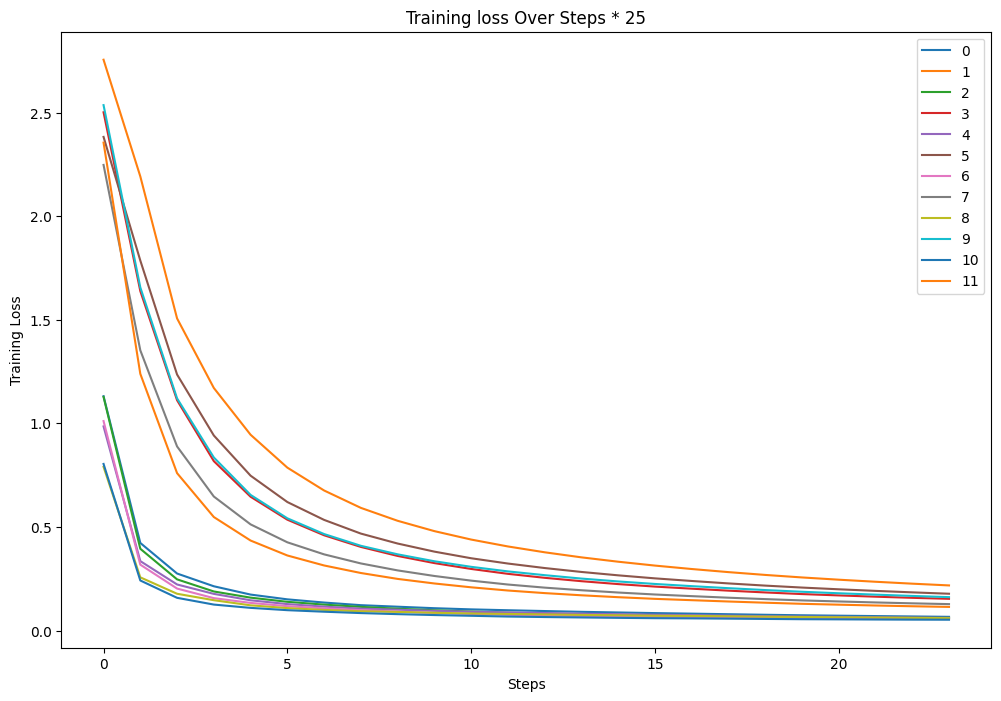

In [20]:

plt.figure(figsize=(12,8))
for res in all_results:
    every_10th_value = res[1][::5]
    label = res[3]
    plt.plot(every_10th_value, label=label)

plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.title('Training loss Over Steps * 25')
plt.legend()
plt.show()

# Results differ a bit based on warmup steps or not

In [25]:
#model = init_model(training_dataset, model_name, tokenizer, device)


model, t_loss, e_loss = train_model(best_hyperparameters, model, training_dataset, evaluation_dataset, hyperparameter_search=False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average T loss at step 25: 0.8955055451393128
Average T loss at step 50: 0.6280729508399964
Average T loss at step 75: 0.4749568537871043
Average T loss at step 100: 0.3872753373160958
Average T loss at step 125: 0.3274633335471153
Average T loss at step 150: 0.2869074508547783
Average T loss at step 175: 0.2595325969159603
Average T loss at step 200: 0.23605282643809913
Average T loss at step 225: 0.21585041732423835
Average T loss at step 250: 0.19931540845893322
Average T loss at step 275: 0.18459607381542975
Average T loss at step 300: 0.1736159895034507
Average T loss at step 325: 0.16525176009163262
Average T loss at step 350: 0.158059066631166
Average T loss at step 375: 0.15166267033542197
Average T loss at step 400: 0.14472935246361884
Average T loss at step 425: 0.13974350040285466
Average T loss at step 450: 0.1345527995300169
Average T loss at step 475: 0.13064980521455016
Average T loss at step 500: 0.12740347671555355
Average T loss at step 525: 0.1242796836478547
Average

Average T loss at step 4250: 0.048474559488487154
Average T loss at step 4275: 0.04843825649965707
Average T loss at step 4300: 0.04834809403281746
Average T loss at step 4325: 0.04818340730016265
Average T loss at step 4350: 0.0479981860195035
Average T loss at step 4375: 0.047831239970494065
Average T loss at step 4400: 0.04767160049413426
Average T loss at step 4425: 0.04755556009548038
Average T loss at step 4450: 0.047425728538204405
Average T loss at step 4475: 0.047302063909286436
Average T loss at step 4500: 0.04712172982466614
Average T loss at step 4525: 0.0470054645925112
Average T loss at step 4550: 0.04687265009452988
Average T loss at step 4575: 0.04675664616870831
Average T loss at step 4600: 0.04669842072959949
Average T loss at step 4625: 0.04666291593143566
Average T loss at step 4650: 0.04653698212773819
Average T loss at step 4675: 0.04639105390385042
Average T loss at step 4700: 0.046303186968942374
Average T loss at step 4725: 0.046193460309890313
Average T loss a

# Evaluation

In [70]:


def exact_match(prediction, labels):
    pass

def partial_match(prediction_labels):
    pass

def per_token_metrics(preds, labels):
    f1 = f1_score(preds, labels)  #
    acc = accuracy_score(preds, labels)  #
    rec = recall_score(preds, labels)  # % of entites found
    prec = precision_score(preds, labels)  # % of entities found that are correct

    return f1, acc, rec, prec


def test(test_loader):
    
    # Batch size is 1, turn to nested list
    
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            _ids, at, lab = batch
            
            # Batch, padded tokenized sentence, classes => B * 70 * 31/11
            out = model(input_ids=_ids.to(model.device), attention_mask=at.to(model.device))
            batch_preds = torch.argmax(out.logits, dim=2)
            
            
            for b in range(_ids.shape[0]):
                mask = lab[b] != -100

                prediction = batch_preds[b][mask].tolist()
                label = lab[b][mask].tolist()

                # Tolist for comparison
                predictions.append(prediction)
                labels.append(label)
    
    return predictions, labels

test_loader = DataLoader(testing_dataset, batch_size=128, shuffle=False)
preds, labels = test(test_loader)

assert set([itos[x] for xs in preds for x in xs]) == set([itos[x] for xs in labels for x in xs])



In [71]:
sum([1 for x,y in zip(preds, labels) if x==y]) / len(labels)

0.9417162999878449

In [29]:

seqeval = evaluate.load('seqeval')

In [72]:

# Because we went integer => integer mapping, we need to reverse this before integer to string to map to the original dict
def mapper(predictions, inverse_label_mapping):
    return [[inverse_label_mapping.get(label_id, 0) for label_id in pred_list] for pred_list in predictions]

mapped_preds = mapper(preds, INVERSE_LABEL_MAPPING)
mapped_labels = mapper(labels, INVERSE_LABEL_MAPPING)

evals = seqeval.compute(
                predictions=[[itos[x] for x in sublist] for sublist in mapped_preds], 
                references=[[itos[x] for x in sublist] for sublist in mapped_labels],
                mode="strict"
)

evals

{'ANIM': {'precision': 0.7082352941176471,
  'recall': 0.7629911280101395,
  'f1': 0.7345942647956071,
  'number': 3156},
 'DIS': {'precision': 0.7378516624040921,
  'recall': 0.7683089214380826,
  'f1': 0.7527723418134378,
  'number': 1502},
 'LOC': {'precision': 0.9945846871615429,
  'recall': 0.9936740469452305,
  'f1': 0.9941291585127201,
  'number': 24028},
 'ORG': {'precision': 0.9803921568627451,
  'recall': 0.9824667472793228,
  'f1': 0.9814283557300316,
  'number': 6616},
 'PER': {'precision': 0.9939232814280289,
  'recall': 0.9950570342205323,
  'f1': 0.9944898346950408,
  'number': 10520},
 'overall_precision': 0.9625856238619613,
 'overall_recall': 0.969097813277465,
 'overall_f1': 0.9658307414576854,
 'overall_accuracy': 0.9900825620464396}

In [54]:
entity_df = pd.DataFrame({k:v for k,v in evals.items() if not k.startswith("overall")}).T.round(3)
entity_df

,precision,recall,f1,number
ANIM,0.708,0.763,0.735,3156.0
BIO,0.738,0.768,0.753,1502.0
LOC,0.995,0.994,0.994,24028.0
ORG,0.980,0.982,0.981,6616.0
PER,0.994,0.995,0.994,10520.0


In [55]:
overall_df = pd.DataFrame({k:v for k,v in evals.items() if k.startswith("overall")}, index=[0]).round(3)
overall_df

,overall_precision,overall_recall,overall_f1,overall_accuracy
0,0.963,0.969,0.966,0.99


In [39]:
import pandas as pd
pd.DataFrame(evals)

,ANIM,BIO,LOC,ORG,PER,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.708235,0.737852,0.994585,0.980392,0.993923,0.962586,0.969098,0.965831,0.990083
recall,0.762991,0.768309,0.993674,0.982467,0.995057,0.962586,0.969098,0.965831,0.990083
f1,0.734594,0.752772,0.994129,0.981428,0.994490,0.962586,0.969098,0.965831,0.990083
number,3156.000000,1502.000000,24028.000000,6616.000000,10520.000000,0.962586,0.969098,0.965831,0.990083


In [74]:
Counter([x for sublist in mapped_labels for x in sublist])

Counter({0: 672514,
         6: 29160,
         2: 27158,
         5: 24028,
         4: 15030,
         1: 10520,
         8: 6632,
         3: 6616,
         14: 4294,
         7: 3156,
         13: 1502})